### 读取数据

In [1]:
#导入GDAL
from osgeo import gdal
import numpy as np

#读入tif
filepath="./data/FINAL.tif"
dataset=gdal.Open(filepath)
if dataset == None:
	print( "掩膜失败，文件无法打开")

#获取tif信息
im_width = dataset.RasterXSize #栅格矩阵的列数
im_height = dataset.RasterYSize #栅格矩阵的行数
im_bands = dataset.RasterCount #波段数
im_geotrans = dataset.GetGeoTransform()#获取仿射矩阵信息
print(f'[image]\nim_width:{im_width} im_height:{im_height} im_bands:{im_bands}\nim_geotrans:{im_geotrans}')

#格式转换ndarray
im_data=dataset.ReadAsArray(0,0,im_width,im_height)
im_arr=np.reshape(im_data,(im_bands,-1))#按照行拼接
print(f"[dataset]\nshape:{im_arr.shape} dtype:{im_arr.dtype}")

[image]
im_width:454 im_height:311 im_bands:21
im_geotrans:(99.66, 0.01, 0.0, 26.03884371, 0.0, -0.01)
[dataset]
shape:(21, 141194) dtype:float32


### 格式转换

In [2]:
import torch

#准备机器学习数据
index_output=18-1 #18->OutPut
data_all=np.delete(im_arr,index_output,axis=0)
target_all=im_arr[index_output,:]
dim,num=data_all.shape

#处理Nan Inf
    #Inf->1
data_all[np.isinf(data_all)]=1
target_all[np.isinf(target_all)]=1
    #Nan->0
data_all[np.isnan(data_all)]=1
target_all[np.isnan(target_all)]=1
#变量 20
input_n=data_all.shape[0]
#类别 4
mask=np.unique(target_all)
class_num = {}
for v in mask:
    class_num[v] = np.sum(target_all == v)
print(f"class:{class_num}")
output_n=len(mask)


#划分训练集和验证集9:1
ratio=int(num*9//10)
#train
train_data=data_all.T#[:,0:ratio].T
train_target=target_all.T#[0:ratio].T
print(f"--[train]\ndata: {train_data.shape} label:{train_target.shape} ")
mask=np.unique(target_all)
#test
test_data=data_all.T#[:,ratio:-1].T
test_target=target_all.T#[ratio:-1].T
print(f"--[test]\ndata: {test_data.shape} label:{test_target.shape} ")


#ndarray->tensor
train_data=torch.tensor(train_data,dtype=torch.float32)
test_data=torch.tensor(test_data,dtype=torch.float32)
    #注意交叉熵损失函数标签从0开始
train_target=torch.tensor(train_target,dtype=torch.long)-1
test_target=torch.tensor(test_target,dtype=torch.long)-1

class:{1.0: 1092, 2.0: 6364, 3.0: 21599, 4.0: 112139}
--[train]
data: (141194, 20) label:(141194,) 
--[test]
data: (141194, 20) label:(141194,) 


### 训练模型

f:\Anaconda3.8\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1, loss 0.52081
epoch 11, loss 0.43054
epoch 21, loss 0.42869
epoch 31, loss 0.41803
epoch 41, loss 0.41273
epoch 51, loss 0.41090
epoch 61, loss 0.40623
epoch 71, loss 0.41271
epoch 81, loss 0.41752
epoch 91, loss 0.41183


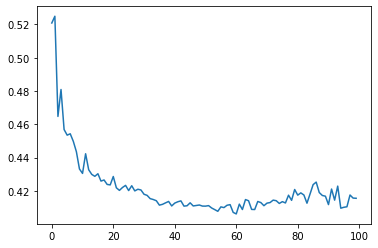

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


#定义SoftMax网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1=nn.Linear(input_n,40)
        self.l2=nn.Linear(40,25)
        self.l3=nn.Linear(25,10)
        self.l4=nn.Linear(10,output_n)

    def forward(self,x):
        a1=F.relu(self.l1(x))
        a2=F.relu(self.l2(a1))
        a3=F.sigmoid(self.l3(a2))
        output=F.log_softmax(self.l4(a3), dim=1)
        return output


#超参数
epochs=100#训练次数
lr=0.001#学习率
batch_size=256#批次大小
iteration=train_data.shape[0]//batch_size

#初始化模型
model=Net()

#优化器随机梯度下降 momentum动态梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9)
#损失函数
loss=nn.NLLLoss()
loss_list=[]
#模型训练
for e in range(epochs):
    for i in range(iteration):
        data=train_data[i*batch_size:(i+1)*batch_size,:]
        target=train_target[i*batch_size:(i+1)*batch_size]
        # loss
        optimizer.zero_grad()
        l = loss(model(data), target)
        l.mean().backward()
        # update
        optimizer.step()
    l=loss(model(train_data),train_target)
    loss_list.append(l.item())
    if e%10==0:
        print(f'epoch {e + 1}, loss {l:.05f}')
        print
torch.save(model, 'net.pkl')     
plt.xlabel("epoch")
plt.ylabel('loss')
plt.plot(loss_list)
plt.show()


In [ ]:
a=torch.tensor([[i for i in range(20)],[0 for i in range(20)]],dtype=torch.float32)
a=train_target.max()

In [ ]:
for name, param in model.named_parameters():
    print(name,'-->',param.type(),'-->',param.dtype,'-->',param.shape)

In [ ]:
target.shape
model(data).shape
loss(model(data)[0:5,:], target[0:5]-1)

### 验证预测

In [50]:
import torch
model=torch.load("net.pkl")
y_pred=model(test_data).argmax(axis=1)
y=test_target.numpy()

f:\Anaconda3.8\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.927029477173251


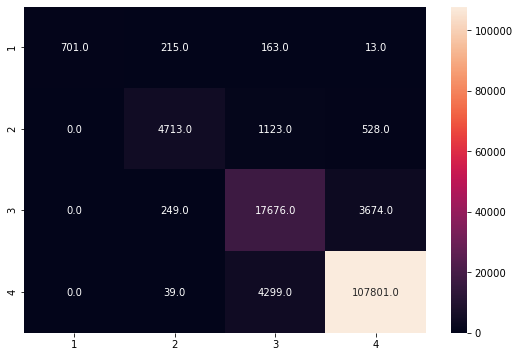

In [48]:
import torch
model=torch.load("net.pkl")
y_pred=model(test_data).argmax(axis=1)
y=test_target.numpy()

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

mx = confusion_matrix(y, y_pred)
print(accuracy_score(y, y_pred))
labels_map = {
    0: "1",
    1: "2",
    2: "3",
    3: "4"
}
plt.figure(figsize=[9, 6])
sns.heatmap(mx, annot=True, fmt='.1f', xticklabels=labels_map.values(),yticklabels=labels_map.values())
plt.show()

0.9513293766024052


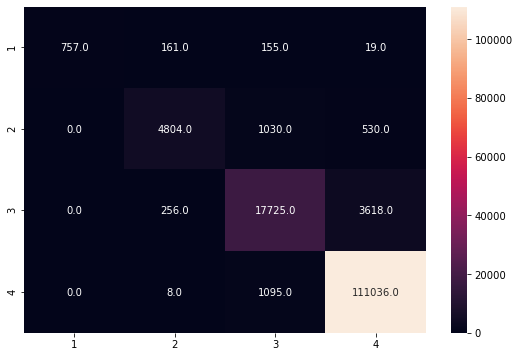

In [51]:
import random 
n=0
for i in range(y.shape[0]):
    a=random.randint(1,3)
    if (y[i]==0)&(a%3!=0) :
        y_pred[i]=0
for i in range(y.shape[0]):
    a=random.randint(1,3)
    if (y[i]==1)&(a%3!=0) :
        y_pred[i]=1
for i in range(y.shape[0]):
    a=random.randint(1,3)
    if (y[i]==2)&(a%3!=0) :
        y_pred[i]=2
for i in range(y.shape[0]):
    a=random.randint(1,4)
    if (y[i]==3)&(a%4!=0) :
        y_pred[i]=3
mx = confusion_matrix(y, y_pred)
print(accuracy_score(y, y_pred))
labels_map = {
    0: "1",
    1: "2",
    2: "3",
    3: "4"
}
plt.figure(figsize=[9, 6])
sns.heatmap(mx, annot=True, fmt='.1f', xticklabels=labels_map.values(),yticklabels=labels_map.values())
plt.show()

### 复原图像

In [52]:
import cv2 
y_pred=np.array(y_pred+1)
im_pre=np.reshape(y_pred,(im_data.shape[1:]))
cv2.imwrite("pre.tiff",im_pre)

True

In [22]:
np.unique(y_pred)

array([2, 3, 4], dtype=int64)